Импортируем библиотеки

In [58]:
import random, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import layers
warnings.filterwarnings('ignore')

Загрузка данных (файлы с датасетами небходимо загурзить в папку data в текущей директории)

In [59]:
images = np.load("data/images.npy")
labels = np.load("data/labels.npy")


Посмотрим на данные

In [60]:
print("images shape:", images.shape)  
print("labels shape:", labels.shape)  
print("min/max label:", labels.min(), labels.max())

images shape: (20000, 48, 48, 3)
labels shape: (20000,)
min/max label: 0 25


Посмотрим распределение классов

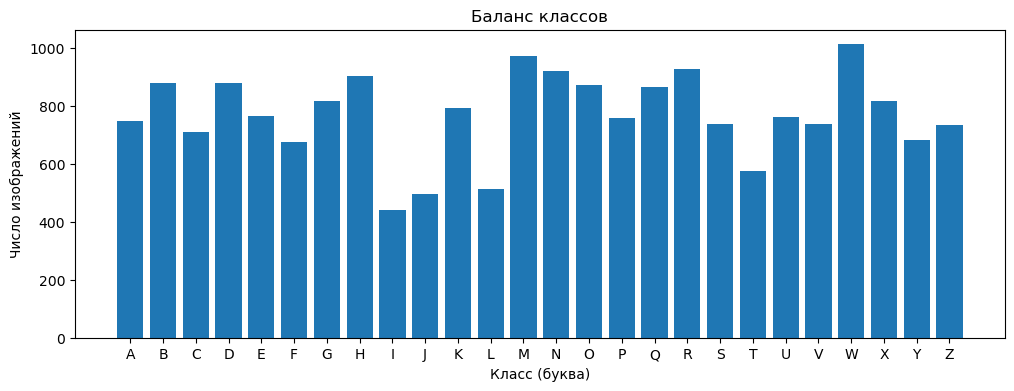

In [61]:
classes, counts = np.unique(labels, return_counts=True)

plt.figure(figsize=(12,4))
plt.bar(classes, counts)
plt.xticks(classes, [chr(65+i) for i in classes])
plt.xlabel("Класс (буква)")
plt.ylabel("Число изображений")
plt.title("Баланс классов")
plt.show()

Выведем на экран по одному-двум образцам из нескольких классов, чтобы понять, как выглядят шум и искажения

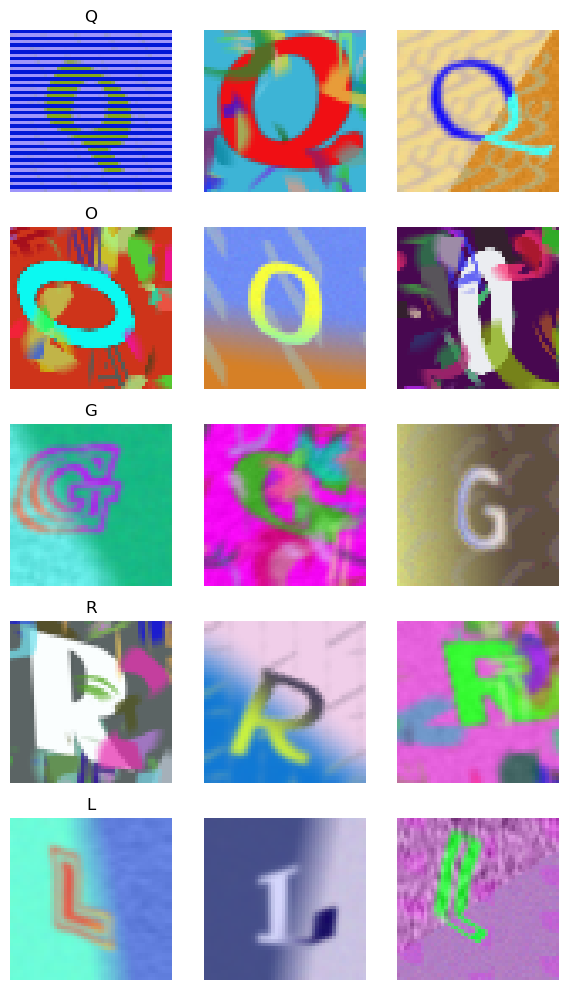

In [62]:
samples_per_class = 3
n_classes = 5
chosen = random.sample(list(range(26)), n_classes)
plt.figure(figsize=(samples_per_class*2, n_classes*2))
for i, cls in enumerate(chosen):
    idxs = np.where(labels == cls)[0]
    sel = np.random.choice(idxs, samples_per_class, replace=False)
    for j, idx in enumerate(sel):
        ax = plt.subplot(n_classes, samples_per_class, i*samples_per_class + j + 1)
        ax.imshow(images[idx])
        ax.axis('off')
        if j == 0:
            ax.set_title(chr(65+cls), fontsize=12)
plt.tight_layout()
plt.show()

Видим, что есть небольшой дисбаланс классов и что данные соответствуют меткам. Попробуем обучить CNN на исходных данных.
Для начала нормализуем данные (пиксели) в рамках диапазона от 0 до 1 и разобъем тестовую и обучающую выборки

In [63]:
images = images.astype("float32") / 255.0

num_classes = 26
labels_cat = keras.utils.to_categorical(labels, num_classes)

X_train, X_val, y_train, y_val = train_test_split(
    images, labels_cat,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape,   y_val.shape)

Train: (16000, 48, 48, 3) (16000, 26)
Val: (4000, 48, 48, 3) (4000, 26)


Определим слои модели

In [64]:
model = keras.Sequential([
    layers.Conv2D(32, 3, padding="same", activation="relu", input_shape=(48,48,3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(2),
    layers.Dropout(0.25),

    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(2),
    layers.Dropout(0.25),

    layers.Conv2D(128, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.Conv2D(128, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(2),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 26)             │         6,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,475,514 (5.63 MB)

 Trainable params: 1,474,554 (5.62 MB)

 Non-trainable params: 960 (3.75 KB)

Обучим модель на обучающей выборке

In [65]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=30,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5),
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.0637 - loss: 3.7316 - val_accuracy: 0.0507 - val_loss: 3.3542 - learning_rate: 0.0010
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3301 - loss: 2.2454 - val_accuracy: 0.5915 - val_loss: 1.4194 - learning_rate: 0.0010
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5883 - loss: 1.3433 - val_accuracy: 0.7393 - val_loss: 0.8810 - learning_rate: 0.0010
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7143 - loss: 0.9288 - val_accuracy: 0.7778 - val_loss: 0.7009 - learning_rate: 0.0010
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7781 - loss: 0.7122 - val_accuracy: 0.8280 - val_loss: 0.5493 - learning_rate: 0.0010
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8254 - loss: 0.5586 - val_accuracy: 0.7720 - val_loss: 0.7892 - learning_rate: 0.0010
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8498 - loss: 0.

Визуализируем результаты обучения

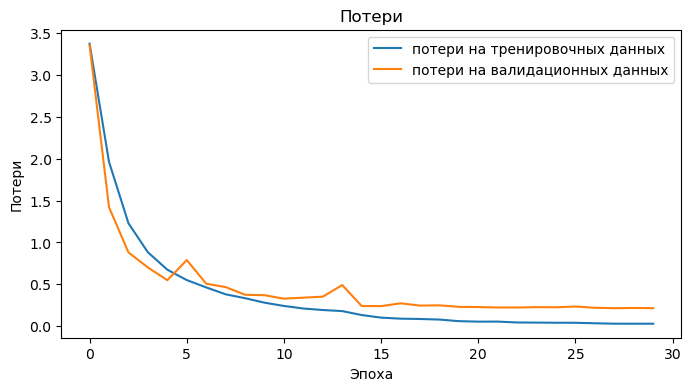

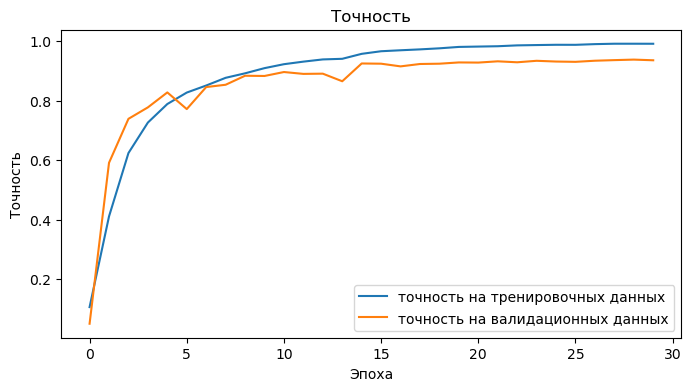

In [66]:
plt.figure(figsize=(8,4))
plt.plot(history.history["loss"], label="потери на тренировочных данных")
plt.plot(history.history["val_loss"], label="потери на валидационных данных")
plt.xlabel("Эпоха")
plt.ylabel("Потери")
plt.title("Потери")
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history.history["accuracy"], label="точность на тренировочных данных")
plt.plot(history.history["val_accuracy"], label="точность на валидационных данных")
plt.xlabel("Эпоха")
plt.ylabel("Точность")
plt.title("Точность")
plt.legend()
plt.show()

По резульатам обучения видим, что модель успешно уменьшала ошибку (потери) и увеличивала точность на протяжении всего процесса обучения.

Попробуем применить обученную модель на тестовых данных для сабмита.

In [67]:
test_images = np.load("data/images_sub.npy").astype("float32") / 255.0

preds_test = model.predict(test_images)
labels_test = preds_test.argmax(axis=1)

submission = pd.DataFrame({
    "Id": range(len(labels_test)),
    "Category": labels_test
})

submission.to_csv("submission.csv", index=False)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


Скриншот с Kaggle

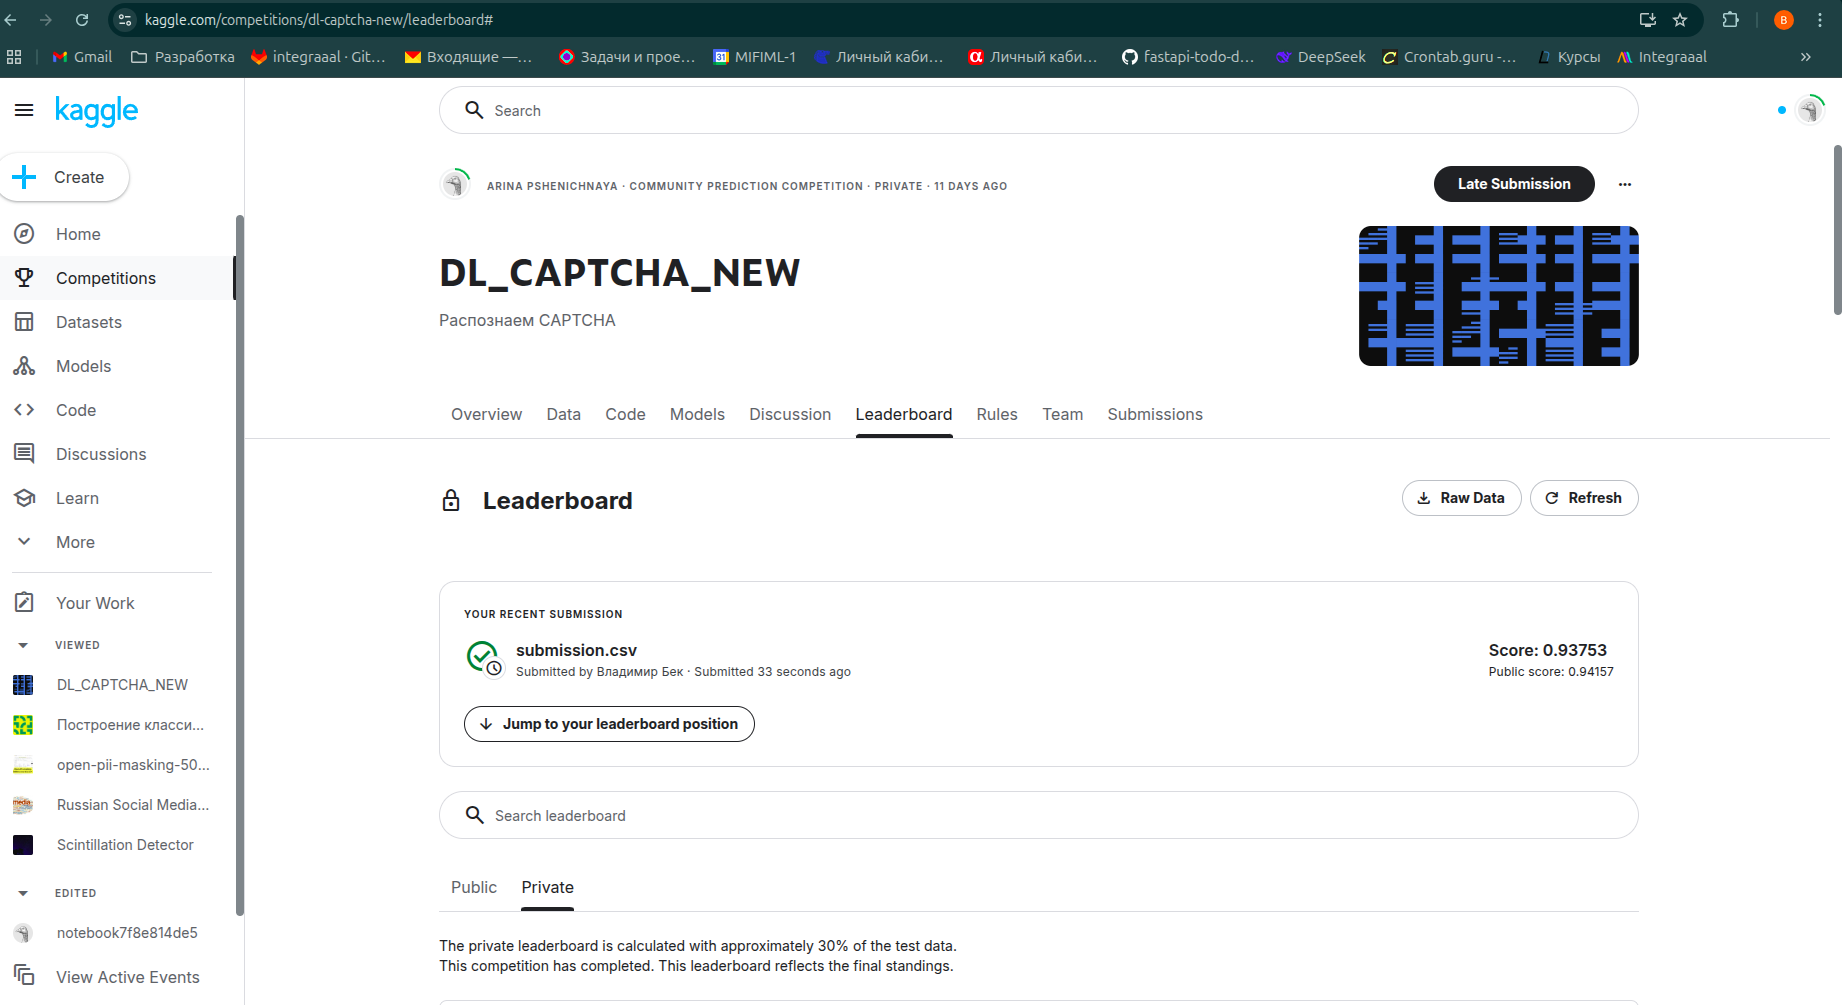